In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import ElasticNet
from nonconformist.cp import IcpRegressor
from nonconformist.cp import IcpClassifier
from nonconformist.nc import NcFactory
import pickle
import re
import warnings
warnings.filterwarnings('ignore')

In [4]:
results = pd.read_csv('data/4_validation_result.csv')
train_input = pd.read_csv('data/3_train_model_input.csv')
test_input = pd.read_csv('data/3_test_model_input.csv')

X_train = train_input.iloc[:,0:6]
y_train = train_input.iloc[:,-1]
X_test = test_input.iloc[:,0:6]
y_test = test_input.iloc[:,-1]

In [5]:
bootstraps = []
for model in list(set(results.model.values)):
    model_df = results.loc[results.model == model]
    bootstrap = model_df.sample(n=50, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

In [6]:
metric_df = results_long_nofit[results_long_nofit.metrics == 'test_neg_mean_squared_error']
metric_df['values'] = (metric_df['values']*(-1))**(1/2)

Text(0.5, 1.0, 'Comparison of Model by RMSE')

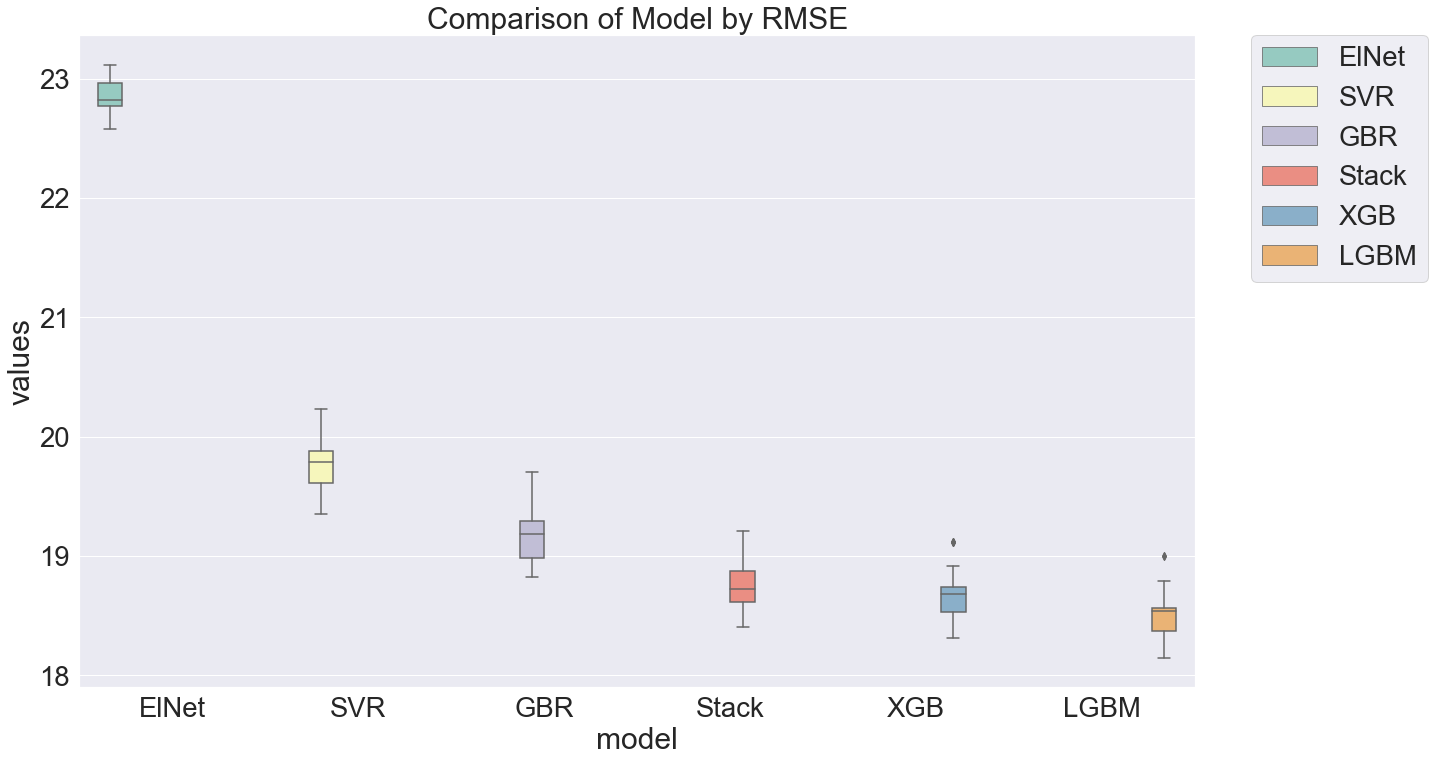

In [7]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="model", data=metric_df, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by RMSE')

In [8]:
metric_df = results_long_nofit[results_long_nofit.metrics == 'test_r2']

Text(0.5, 1.0, 'Comparison of Model by R-squared')

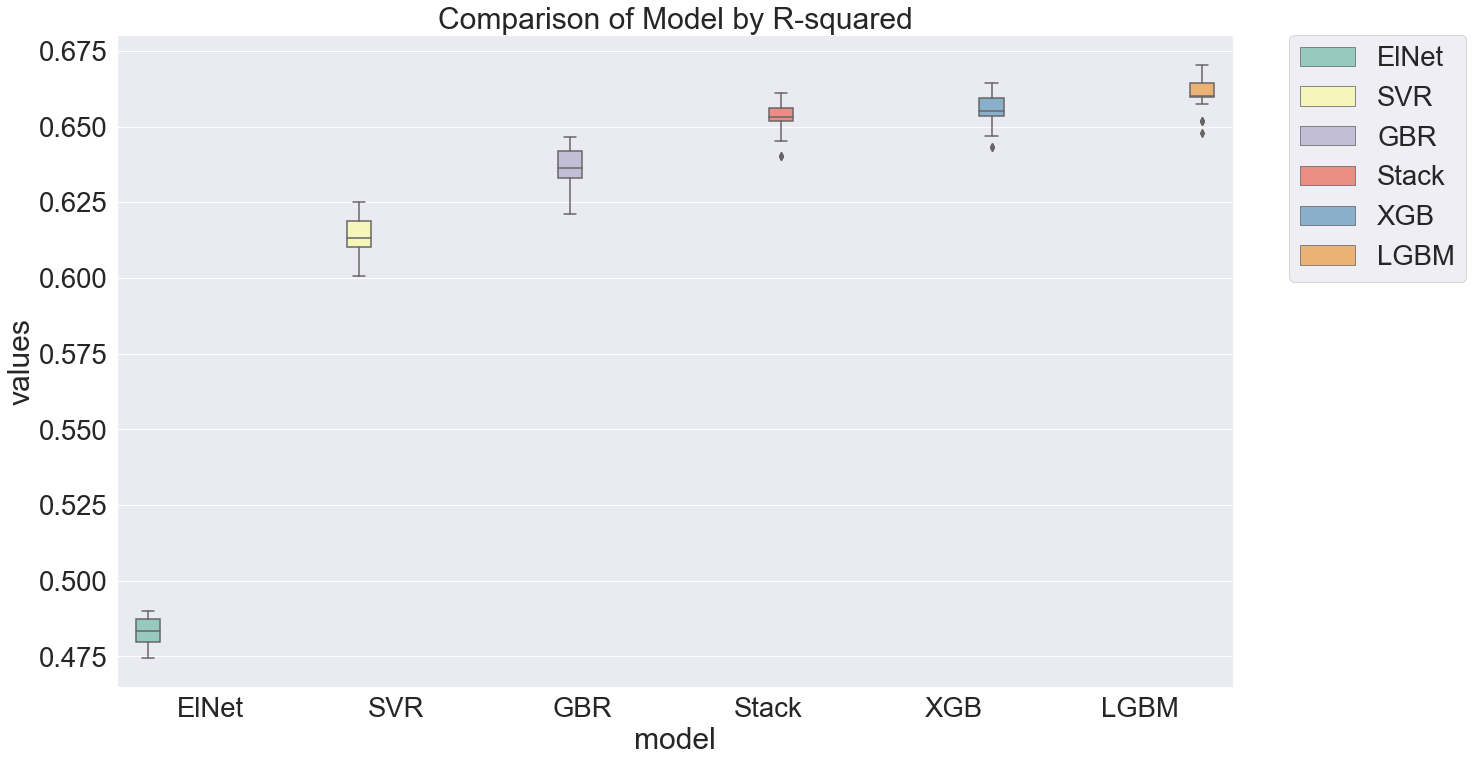

In [9]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="model", data=metric_df, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by R-squared')

Text(0.5, 1.0, 'Comparison of Model by Fit Time')

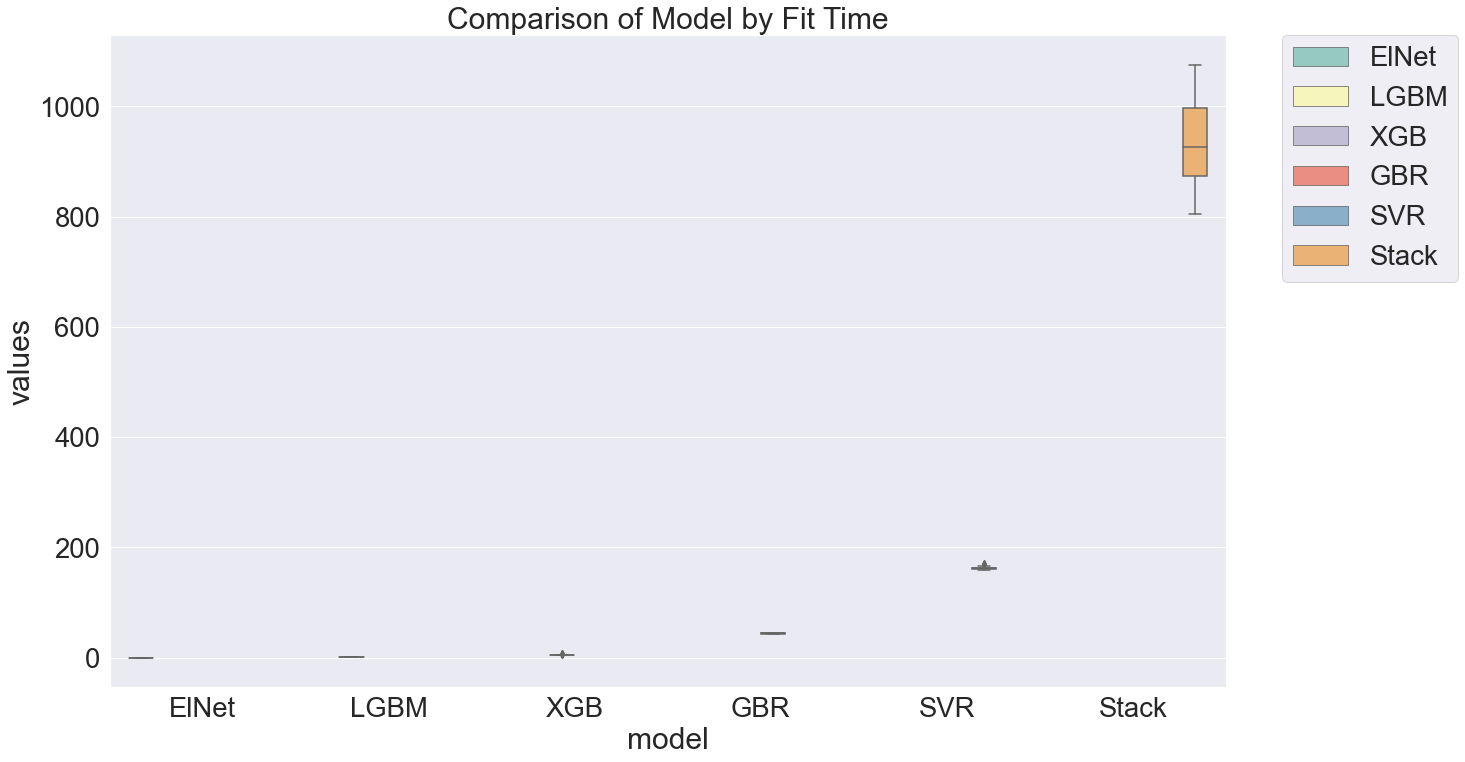

In [10]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="model", data=results_long_fit[results_long_fit.metrics =='fit_time'], palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit Time')
#plt.savefig('./benchmark_models_time.png',dpi=300)

Text(0.5, 1.0, 'Comparison of Model by FitTime')

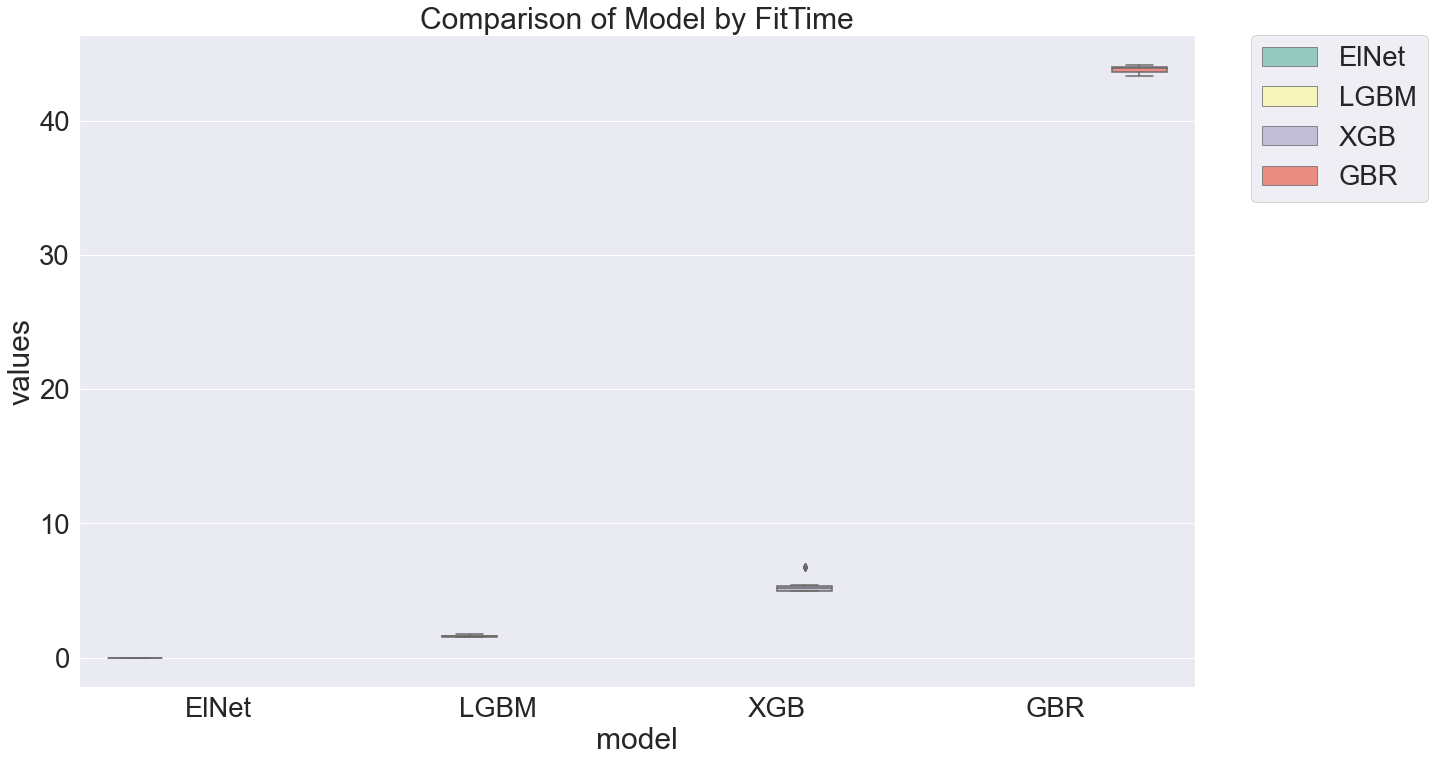

In [11]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="model", data=results_long_fit[(results_long_fit.metrics =='fit_time') & 
                                                                            (results_long_fit.model != 'Stack') &
                                                                           (results_long_fit.model != 'SVR')], palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by FitTime')

In [12]:
metric_df['values'] = (metric_df['values']*(-1))**(1/2)
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_r2           test_neg_mean_absolute_error             \
            std      mean                          std       mean   
model                                                               
ElNet  0.004690  0.483271                     0.083196 -17.308723   
GBR    0.007850  0.635266                     0.146158 -13.564134   
LGBM   0.006048  0.661092                     0.142812 -12.804015   
SVR    0.007115  0.613706                     0.108619 -13.610315   
Stack  0.005583  0.652604                     0.133915 -13.157597   
XGB    0.005745  0.655043                     0.132189 -12.922853   

      test_neg_mean_squared_error              
                              std        mean  
model                                          
ElNet                    6.850493 -522.684689  
GBR                     10.024071 -368.950008  
LGBM                     7.730819 -342.175977  
SVR                      8.382472 -390.379048  
Stack                    7.805810 -351.767179  
XGB                      7.631985 -348.482522

In [13]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

fit_time             score_time          
             std        mean        std      mean
model                                            
ElNet   0.001583    0.009620   0.000367  0.003030
GBR     0.252195   43.836881   0.001673  0.053246
LGBM    0.065954    1.625815   0.005647  0.107288
SVR     2.466542  162.285936   0.134748  9.522021
Stack  80.212697  935.783757   0.881174  9.317875
XGB     0.499347    5.306367   0.001701  0.013410

In [14]:
GBR = pickle.load(open('models/GBR.sav', 'rb'))
LGBM = pickle.load(open('models/LGBM.sav', 'rb'))
Stack = pickle.load(open('models/Stack.sav', 'rb'))
SVR = pickle.load(open('models/SVR.sav', 'rb'))
XGB = pickle.load(open('models/XGB.sav', 'rb'))
ElNet = pickle.load(open('models/ElNet.sav', 'rb'))

In [15]:
train_percentage = 0.8
cal_percentage = 0.2
n_total = X_train.shape[0]
n_train = int(train_percentage*n_total)
n_cal = int(cal_percentage*n_total) + n_train
train_data = X_train.iloc[:n_train, :]
train_target = y_train.iloc[:n_train]
cal_data = X_train.iloc[n_train:n_cal, :]
cal_target = y_train.iloc[n_train:n_cal]
test_data = X_test
test_target = y_test

In [16]:
def PI(model, level1, level2):
    
    # Default nonconformity measure
    nc = NcFactory.create_nc(model)
    # Inductive conformal regressor
    icp = IcpRegressor(nc)
    # Fit the ICP using the proper training set
    icp.fit(train_data.values, train_target.values)
    # Calibrate the ICP using the calibration set
    icp.calibrate(cal_data.values, cal_target.values)

    # Produce predictions for the test set
    prediction1 = icp.predict(test_data.values, significance=(1-level1))
    lower_1 = prediction1[:, 0]
    upper_1 = prediction1[:, 1]

    prediction2 = icp.predict(test_data.values, significance=(1-level2))
    lower_2 = prediction2[:, 0]
    upper_2 = prediction2[:, 1]

    df_50 = pd.DataFrame()
    df_80 = pd.DataFrame()
    df_50 = df_50.append(pd.DataFrame({'pred': model.predict(test_data.values),
                      'LB': lower_1,
                      'UB': upper_1}
                     ))
    
    df_80 = df_80.append(pd.DataFrame({'pred': model.predict(test_data.values),
                      'LB': lower_2,
                      'UB': upper_2}
                     ))
        
    return df_50, df_80

In [17]:
%%time
PI_LGBM = PI(LGBM,0.5,0.8)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=50, subsample_freq=0 will be ignored. Current value: bagging_freq=50
CPU times: user 5.54 s, sys: 79.5 ms, total: 5.62 s
Wall time: 1.59 s


In [18]:
%%time
PI_SVR = PI(SVR,0.5,0.8)

CPU times: user 3min 2s, sys: 1.5 s, total: 3min 3s
Wall time: 3min 6s


In [19]:
%%time
PI_ElNet = PI(ElNet,0.5,0.8)

CPU times: user 586 ms, sys: 43.3 ms, total: 630 ms
Wall time: 419 ms


In [20]:
%%time
PI_GBR = PI(GBR,0.5,0.8)

CPU times: user 43.1 s, sys: 386 ms, total: 43.5 s
Wall time: 44.3 s


In [21]:
%%time
PI_XGB = PI(XGB,0.5,0.8)

CPU times: user 17.3 s, sys: 180 ms, total: 17.5 s
Wall time: 4.9 s


In [22]:
%%time
PI_Stack = PI(Stack, 0.5,0.8)

CPU times: user 17min 10s, sys: 7.35 s, total: 17min 17s
Wall time: 14min 59s


In [23]:
def intervalScore(predObj,actual,level):
    n = len(predObj)
    alpha = 1 - level
    upper = predObj.loc[:,'UB']
    lower = predObj.loc[:,'LB']
    ilow = (actual.values<lower)
    ihigh = (actual.values>upper)
    sumlength = sum(upper-lower)
    sumlow = sum(predObj.loc[ilow,'LB']-actual.values[ilow])*2/alpha
    sumhigh = sum(actual.values[ihigh]-predObj.loc[ihigh,'UB'])*2/alpha
    avglength = sumlength/n
    IS = (sumlength+sumlow+sumhigh)/n # average length + average under/over penalties
    cover = ((actual.values>= lower) & (actual.values<=upper)).mean()
    summ = pd.DataFrame(np.array([[level,avglength,IS,cover]]), columns = ['level','avglength', 'IS', 'cover'])
    return summ

In [24]:
intervalScore(PI_LGBM[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,17.292233,44.032818,0.493078


In [25]:
intervalScore(PI_LGBM[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,40.01516,68.963069,0.790261


In [26]:
intervalScore(PI_GBR[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,18.858984,45.449898,0.489322


In [27]:
intervalScore(PI_GBR[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,41.873085,70.157203,0.799513


In [28]:
intervalScore(PI_XGB[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,17.461028,44.205556,0.49113


In [29]:
intervalScore(PI_XGB[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,39.901018,69.033989,0.788104


In [30]:
intervalScore(PI_ElNet[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,26.71882,56.046959,0.499478


In [31]:
intervalScore(PI_ElNet[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,55.011715,82.333194,0.805983


In [32]:
intervalScore(PI_SVR[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,18.523849,46.230901,0.494539


In [33]:
intervalScore(PI_SVR[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,42.462843,72.444162,0.798678


In [34]:
intervalScore(PI_Stack[0], test_target, 0.5)

,level,avglength,IS,cover
0,0.5,18.196567,44.446112,0.496974


In [35]:
intervalScore(PI_Stack[1], test_target, 0.8)

,level,avglength,IS,cover
0,0.8,40.690589,69.124409,0.7936


| **Model** | **Level** | **Avg Length** | **IS** | **Coverage** | |
|---|---|---|---|---|---|
| LGBM | 0.5|23.675021|58.053079|0.493913 | |
| SVR | 0.5  | 23.266499  | 57.622133 | 0.502122 | |
| GBR | 0.5|24.705315|58.114026|0.506226 | |
|Elnet| 0.5|29.155639|65.155167|0.50087| |
| XGB | 0.5|23.855599|57.693341|0.504765 | |
| Stack | 0.5 | 24.337802 | 57.656382 |0.505113 | * |

| **Model** | **Level** | **Avg Length** | **IS** | **Coverage** | |
|---|---|---|---|---|---|
| LGBM | 0.8|54.604375|89.739934|0.79847 | |
| SVR | 0.8 | 53.119757 | 89.999751 | 0.792765 | |
| GBR | 0.8|54.755009|89.174804|0.794643 | |
|ElNet| 0.8|64.46488|96.675231|0.798817 | |
| XGB | 0.8|54.164624|89.305558|0.7992355 | |
| Stack | 0.8 | 54.447974 | 88.648392 |0.797287|* |

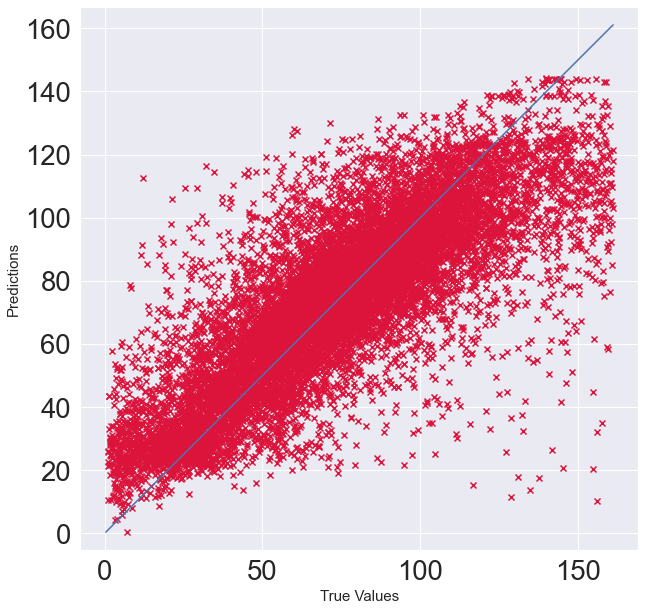

In [36]:
plt.figure(figsize=(10,10))
plt.scatter(test_target, PI_Stack[0].iloc[:,0], c='crimson',marker = 'x')

p1 = max(max(PI_Stack[0].iloc[:,0]), max(test_target))
p2 = min(min(PI_Stack[0].iloc[:,0]), min(test_target))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

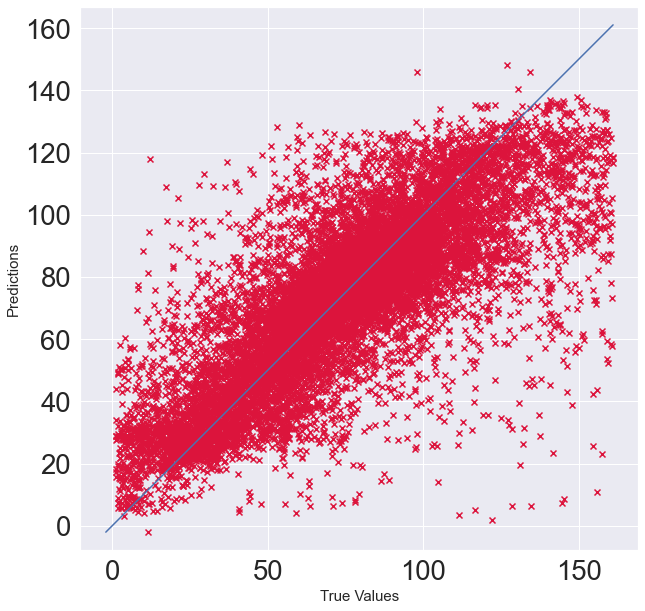

In [37]:
plt.figure(figsize=(10,10))
plt.scatter(test_target, PI_SVR[0].iloc[:,0], c='crimson',marker = 'x')

p1 = max(max(PI_SVR[0].iloc[:,0]), max(test_target))
p2 = min(min(PI_SVR[0].iloc[:,0]), min(test_target))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()